In [20]:
# this implementation follows WaveNet: A Generative Model for Raw Audio by Aaron et al. 2016

In [19]:
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import random
random.seed(10110609)

%matplotlib inline

In [3]:
companies_df = pd.read_csv(
  "../data/cleansed_layer/companies_usa_size_over_10.csv", usecols=["name"]
)

companies = companies_df.name.to_list()

In [4]:
alphabet = sorted(set("".join(companies)))
alphabet.insert(0, '.')
len_alphabet = len(alphabet)
print(f"{len_alphabet=}")

strtoint = {j: i for i, j in enumerate(alphabet)}
inttostr = {i: j for i, j in enumerate(alphabet)}

len_alphabet=27


In [5]:
print("5 examples: ", companies[:5])
print(f"Length: {len(companies)}")
print(f"Max length: {max([len(c) for c in companies])}")
print(f"Min length: {min([len(c) for c in companies])}")
avg_len = sum([len(c) for c in companies]) / len(companies)
print(f"Avg length: {avg_len}")

5 examples:  ['equinoxys', 'biassync', 'taggpay', 'touchpointe', 'rxfit']
Length: 91073
Max length: 16
Min length: 3
Avg length: 8.164823822647767


In [6]:
random.shuffle(companies)

In [7]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = strtoint[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(companies))
n2 = int(0.9*len(companies))
Xtr,  Ytr  = build_dataset(companies[:n1])
Xdev, Ydev = build_dataset(companies[n1:n2])
Xte,  Yte  = build_dataset(companies[n2:])

torch.Size([668185, 8]) torch.Size([668185])
torch.Size([83202, 8]) torch.Size([83202])
torch.Size([83281, 8]) torch.Size([83281])


In [8]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(inttostr[ix.item()] for ix in x), '-->', inttostr[y.item()])

........ --> m
.......m --> a
......ma --> n
.....man --> a
....mana --> g
...manag --> e
..manage --> d
.managed --> o
managedo --> f
anagedof --> f
nagedoff --> i
agedoffi --> c
gedoffic --> e
edoffice --> .
........ --> i
.......i --> d
......id --> m
.....idm --> a
....idma --> t
...idmat --> r


In [9]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    # kaiming init, Kaiming_Delving Deep into Rectifiers_2015
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers, calculated during training on the fly
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # forward propogation
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      # batch mean and variance
      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    # normalize
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    # update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]


class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []


class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [10]:
torch.manual_seed(1006091011);

In [11]:

n_embd = 24 # the dim of embedding vectors
n_hidden = 128 # the num of neurons in hidden layer
model = Sequential([
  Embedding(len_alphabet, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, len_alphabet),
])


# making last layer less confident, it is kind of regularization to prevent overfitting
with torch.no_grad():
  model.layers[-1].weight *= 0.1

params = model.parameters()
print("Total number of parameters: ", sum(p.nelement() for p in params))
for p in params:
  p.requires_grad = True

Total number of parameters:  76579


In [13]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward propogation
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward propogation
  for p in params:
    p.grad = None
  loss.backward()
  
  # optimization (SGD)
  # lr and decayed lr
  lr = 0.1 if i < 150000 else 0.01
  for p in params:
    p.data += -lr * p.grad

  # statistics
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3183
  10000/ 200000: 2.5846
  20000/ 200000: 2.2815
  30000/ 200000: 2.3954
  40000/ 200000: 2.5246
  50000/ 200000: 2.4565
  60000/ 200000: 2.6810
  70000/ 200000: 2.8022
  80000/ 200000: 1.9446
  90000/ 200000: 2.4474
 100000/ 200000: 2.2825
 110000/ 200000: 2.4511
 120000/ 200000: 2.2988
 130000/ 200000: 2.5002
 140000/ 200000: 2.0720
 150000/ 200000: 2.4265
 160000/ 200000: 2.3764
 170000/ 200000: 2.4522
 180000/ 200000: 2.3253
 190000/ 200000: 2.2953


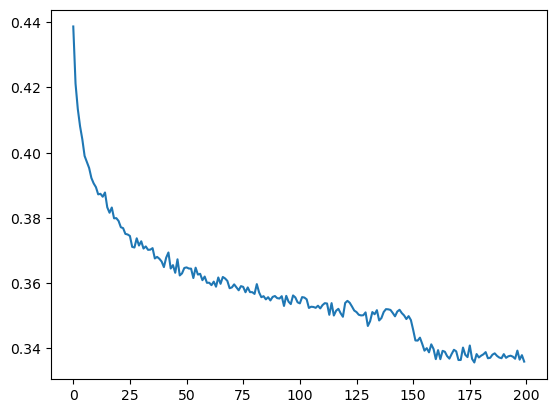

In [33]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [14]:
# eval mode for the batchnorm
for layer in model.layers:
  layer.training = False

In [15]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# split_loss('train')
split_loss('val')

val 2.213277578353882


# Save the Model

In [16]:
with open("../data/model_layer/wavenet_model.pkl", "wb") as f:
  pickle.dump(model, f)

In [13]:
with open("../data/model_layer/wavenet_model.pkl", "rb") as f:
  model = pickle.load(f)

# Sampling from the Moldel (Model Inference)

In [17]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
      # forward
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the window
      context = context[1:] + [ix]
      out.append(ix)
      # break when encountered special token
      if ix == 0:
        break

    print(''.join(inttostr[i] for i in out))

wurewartiva.
timnsco.
balloub.
socience.
opmus.
tranvideo.
hirdactwl.
intellavids.
opeq.
niflywel.
carrage.
alphars.
piselluvweet.
copssttees.
homeline.
pakennockle.
redfir.
storytiglow.
group.
keyibas.
